 # SOLAR POWER PLANT ANALYSIS and FORECASTING

This data has been gathered at two solar power plants over a 34 day period. It has two pairs of files - each pair has one power generation dataset and one sensor readings dataset. The power generation datasets are gathered at the inverter level - each inverter has multiple lines of solar panels attached to it. The sensor data is gathered at a plant level - single array of sensors optimally placed at the plant.

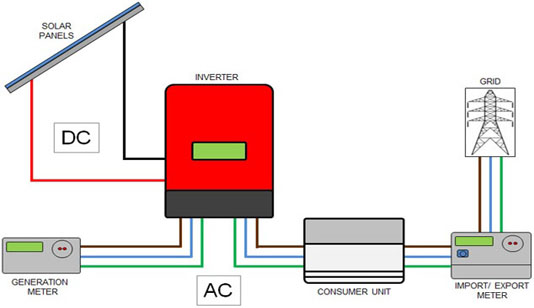

PV inverter convert battery or PV array DC power to AC power for use with conventional utility-powered appliances. It is heart of PV systems because PV array is a DC source, an inverter is required to convert the dc power to normal ac power that is used in our homes and offices.

Typically the factors that determine the performance of a solar power plant are:
* Temperature
* Dirtiness
* Inverters Efficiency
* Inverters or panels seniority

In this paper we will answer two main question:

Can we identify faulty or suboptimally performing equipment?   
Can we predict the power generation for next couple of days? - this allows for better grid management

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt

plt.style.use('fivethirtyeight')

In [173]:
gen1 = pd.read_csv(r'C:\Users\Fabio\Desktop\Data Science\Kaggle Projects\Solar Plant Generation\Plant_1_Generation_Data.csv')
weather1 = pd.read_csv(r'C:\Users\Fabio\Desktop\Data Science\Kaggle Projects\Solar Plant Generation\Plant_1_Weather_Sensor_Data.csv')

gen2 = pd.read_csv(r'C:\Users\Fabio\Desktop\Data Science\Kaggle Projects\Solar Plant Generation\Plant_2_Generation_Data.csv')
weather2 = pd.read_csv(r'C:\Users\Fabio\Desktop\Data Science\Kaggle Projects\Solar Plant Generation\Plant_2_Weather_Sensor_Data.csv')

In [174]:
gen2.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15 00:00:00,4136001,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06
1,2020-05-15 00:00:00,4136001,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09
2,2020-05-15 00:00:00,4136001,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09
3,2020-05-15 00:00:00,4136001,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06
4,2020-05-15 00:00:00,4136001,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07


In [175]:
weather2.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,4136001,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,4136001,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,4136001,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0


In [176]:
gen1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB


In [177]:
#format DATE_TIME
gen1['DATE_TIME']= pd.to_datetime(gen1['DATE_TIME'], format='%d-%m-%Y %H:%M', errors='coerce')
weather1['DATE_TIME'] = pd.to_datetime(weather1['DATE_TIME'], format ='%Y-%m-%d')

gen2['DATE_TIME']= pd.to_datetime(gen2['DATE_TIME'], format='%Y-%m-%d %H:%M', errors='coerce')
weather2['DATE_TIME'] = pd.to_datetime(weather2['DATE_TIME'], format ='%Y-%m-%d')

In [178]:
gen2.tail()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
67693,2020-06-17 23:45:00,4136001,q49J1IKaHRwDQnt,0.0,0.0,4157.0,520758.0
67694,2020-06-17 23:45:00,4136001,rrq4fwE8jgrTyWY,0.0,0.0,3931.0,121131356.0
67695,2020-06-17 23:45:00,4136001,vOuJvMaM2sgwLmb,0.0,0.0,4322.0,2427691.0
67696,2020-06-17 23:45:00,4136001,xMbIugepa2P7lBB,0.0,0.0,4218.0,106896394.0
67697,2020-06-17 23:45:00,4136001,xoJJ8DcxJEcupym,0.0,0.0,4316.0,209335741.0


In [179]:
#Lets sum up the data coming from the different inverters.
group1 = gen1.groupby('DATE_TIME').sum().reset_index()

group2 = gen2.groupby('DATE_TIME').sum().reset_index()

In [180]:
group1['TIME'] = group1['DATE_TIME'].dt.time
group1['DATE'] = group1['DATE_TIME'].dt.date
group1 = group1.drop(columns=['DATE_TIME','PLANT_ID'], axis=1)

group2['TIME'] = group2['DATE_TIME'].dt.time
group2['DATE'] = group2['DATE_TIME'].dt.date
group2 = group2.drop(columns=['DATE_TIME','PLANT_ID'], axis=1)

In [181]:
group2

,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,TIME,DATE
0,0.0,0.0,48899.938095,1.418960e+10,00:00:00,2020-05-15
1,0.0,0.0,28401.000000,1.418960e+10,00:15:00,2020-05-15
2,0.0,0.0,28401.000000,1.418960e+10,00:30:00,2020-05-15
3,0.0,0.0,28401.000000,1.418960e+10,00:45:00,2020-05-15
4,0.0,0.0,26516.000000,1.418960e+10,01:00:00,2020-05-15
...,...,...,...,...,...,...
3254,0.0,0.0,93040.000000,1.419408e+10,22:45:00,2020-06-17
3255,0.0,0.0,93040.000000,1.419408e+10,23:00:00,2020-06-17
3256,0.0,0.0,93040.000000,1.419408e+10,23:15:00,2020-06-17
3257,0.0,0.0,93040.000000,1.419408e+10,23:30:00,2020-06-17


## AC-DC power

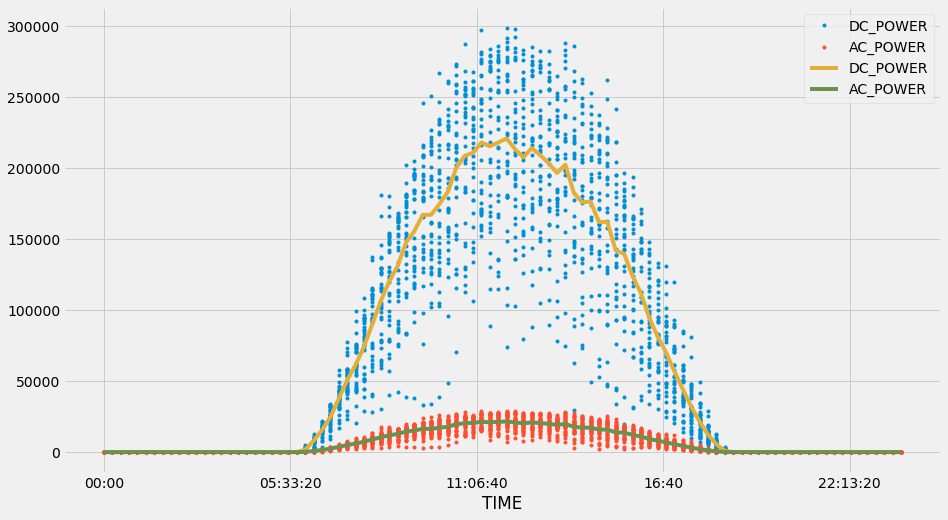

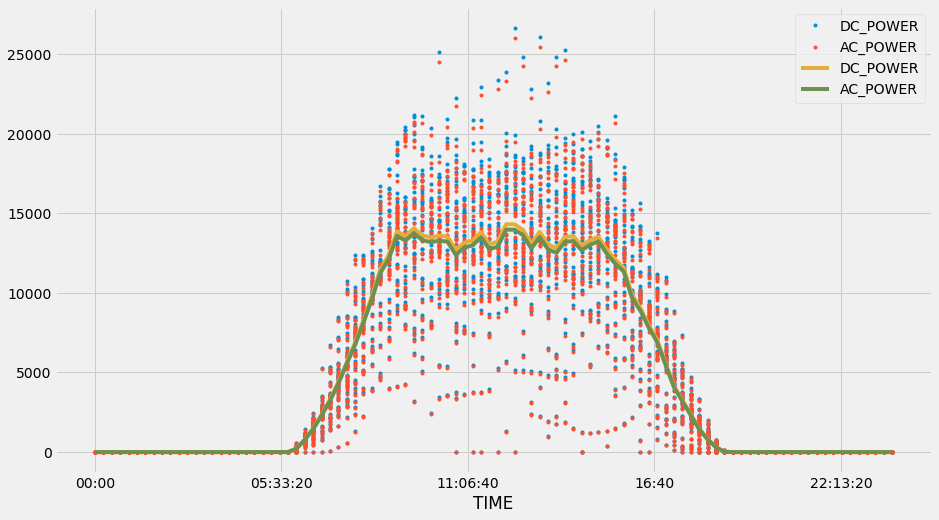

In [182]:
group1.plot(x='TIME',y=['DC_POWER','AC_POWER'], style='.', figsize = (14, 8))
group1.groupby('TIME')['DC_POWER'].agg('mean').plot(legend=True)
group1.groupby('TIME')['AC_POWER'].agg('mean').plot(legend=True)

group2.plot(x='TIME',y=['DC_POWER','AC_POWER'], style='.', figsize = (14, 8))
group2.groupby('TIME')['DC_POWER'].agg('mean').plot(legend=True)
group2.groupby('TIME')['AC_POWER'].agg('mean').plot(legend=True)

## Irradiation,Ambient and Module temperature

Text(0.5, 1.0, 'IRRADIATION COMPARISON')

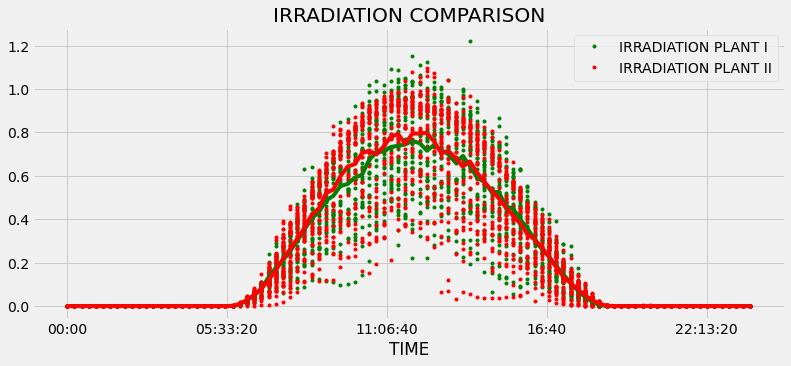

In [183]:
weather1['TIME'] = weather1['DATE_TIME'].dt.time
weather1['DATE'] = weather1['DATE_TIME'].dt.date

weather2['TIME'] = weather2['DATE_TIME'].dt.time
weather2['DATE'] = weather2['DATE_TIME'].dt.date

#compare IRRADIATION PLANT I VS PLANT II
aq = weather1.plot(x='TIME', y='IRRADIATION', legend=True, label='IRRADIATION PLANT I', color='Green', style='.', figsize=(12,5))
weather2.plot(x='TIME', y='IRRADIATION', legend=True, label='IRRADIATION PLANT II',  color='Red', style='.', ax=aq)

weather1.groupby('TIME')['IRRADIATION'].agg('mean').plot(color='Green')
weather2.groupby('TIME')['IRRADIATION'].agg('mean').plot(color='Red')

plt.title('IRRADIATION COMPARISON')

Text(0.5, 1.0, 'Ambient and Module temperature Plant II')

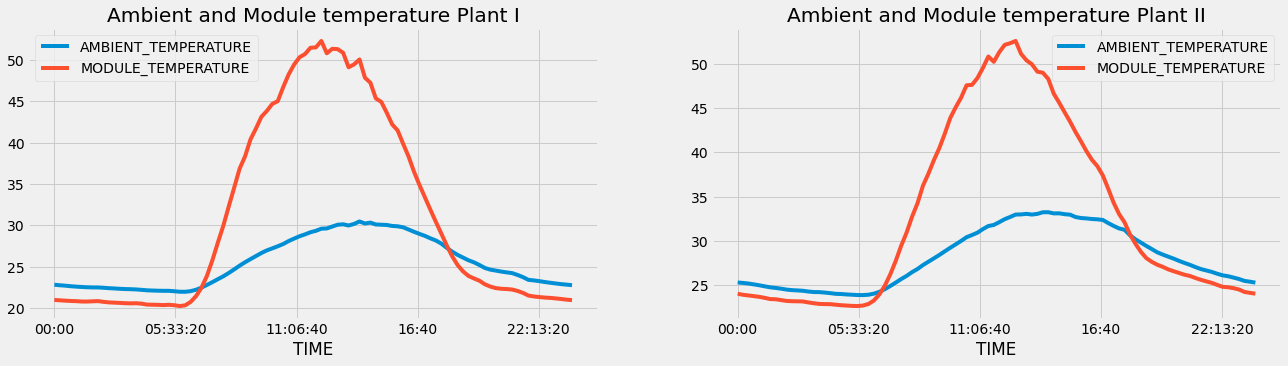

In [184]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
weather1.groupby('TIME')[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']].agg('mean').plot(legend=True,ax=ax[0])
weather2.groupby('TIME')[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']].agg('mean').plot(legend=True,ax=ax[1])

ax[0].set_title('Ambient and Module temperature Plant I')
ax[1].set_title('Ambient and Module temperature Plant II')

### Can we identify faulty performing equipment?

Lets look closer to the rate of conversion DC to AC power, this task is performed by the inverters. Typical grid-tied inverter efficiencies exceed 95% under most operating conditions.

In [185]:
conv1 = group1.copy()

conv1 = conv1.groupby('DATE').sum()
conv1['Conv_rate'] = conv1['AC_POWER']/conv1['DC_POWER']*100

conv2 = group2.copy()

conv2 = conv2.groupby('DATE').sum()
conv2['Conv_rate'] = conv2['AC_POWER']/conv2['DC_POWER']*100

Text(0.5, 1.0, '% of DC power converted in AC power')

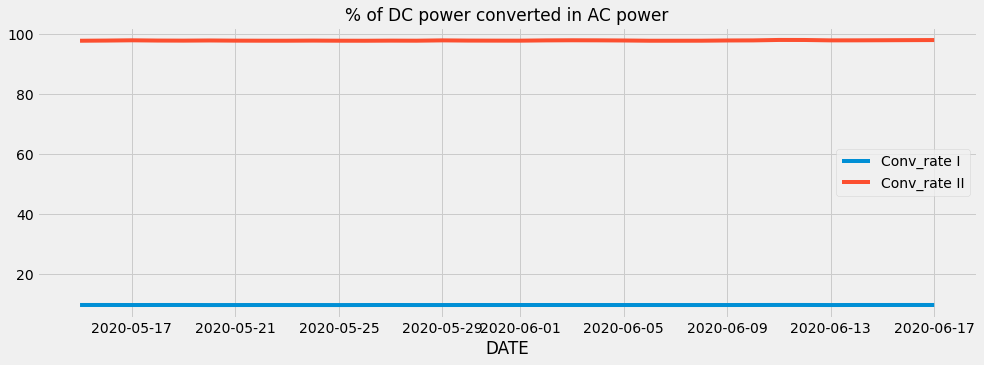

In [186]:
conv1['Conv_rate'].plot(figsize=(15,5))
conv2['Conv_rate'].plot(figsize=(15,5))

plt.legend(['Conv_rate I','Conv_rate II'])
plt.title('% of DC power converted in AC power',size=17)

As we can see above PLANT_I it's able to convert about only 9-10 % of DC POWER produced by module: Inverters are inefficient!

### Lets identify the inverters in the plant I that could have a lower performance and should be checked.

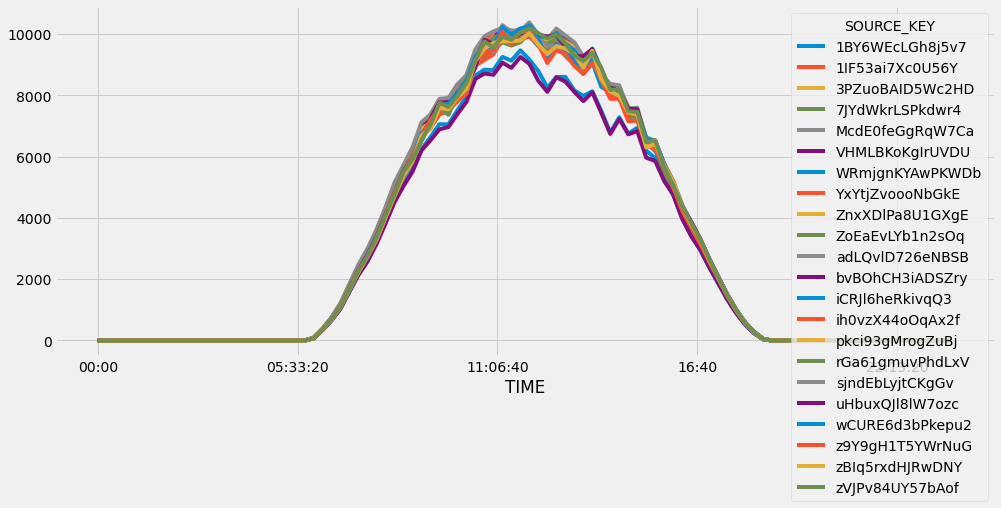

In [187]:
inv1 = gen1.copy()

inv1['TIME'] = inv1['DATE_TIME'].dt.time

fig,ax = plt.subplots(figsize=(15,6))
inv1.groupby(['TIME','SOURCE_KEY']).mean()['DC_POWER'].unstack().plot(ax=ax)

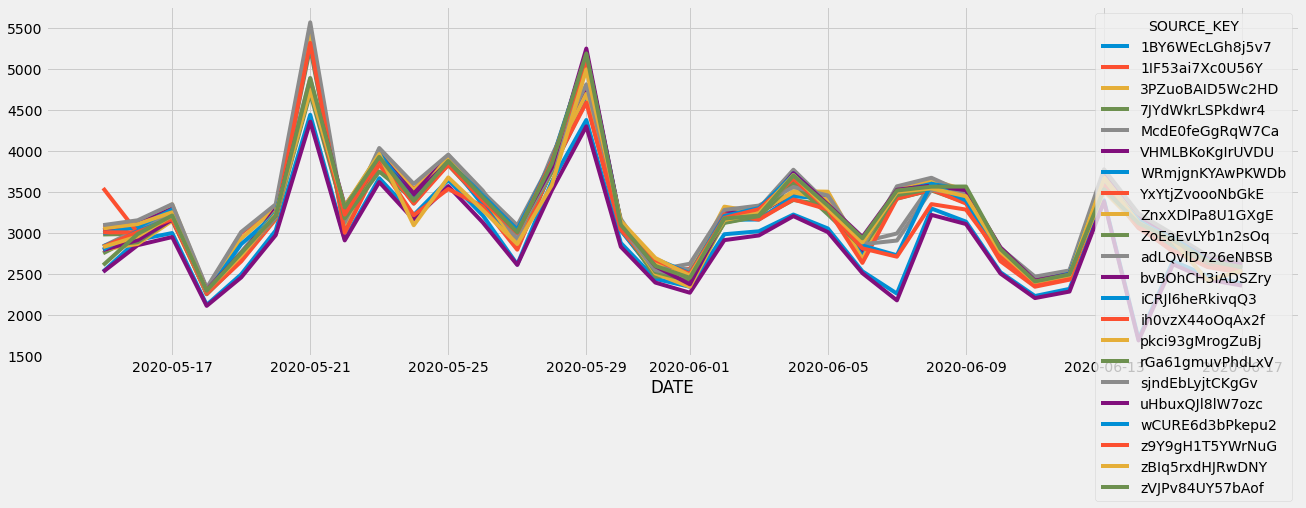

In [188]:
inv1['DATE'] = inv1['DATE_TIME'].dt.date

fig,ax = plt.subplots(figsize=(20,6))
inv1.groupby(['DATE','SOURCE_KEY']).mean()['DC_POWER'].unstack().plot(ax=ax)

Here we can see, clearly, that 1BY6WEcLGh8j5v7 & bvBOhCH3iADSZry are underperforming compared to other inverters and the performance is getting worse with the time, maybe these inverters or the panels attached require maintenance or require to be replaced. 
   
But before going into deep with underperforming inverters, let's look at which are the common problems for the entire plant,so let's see DC power generation during day hours for all 34 days.

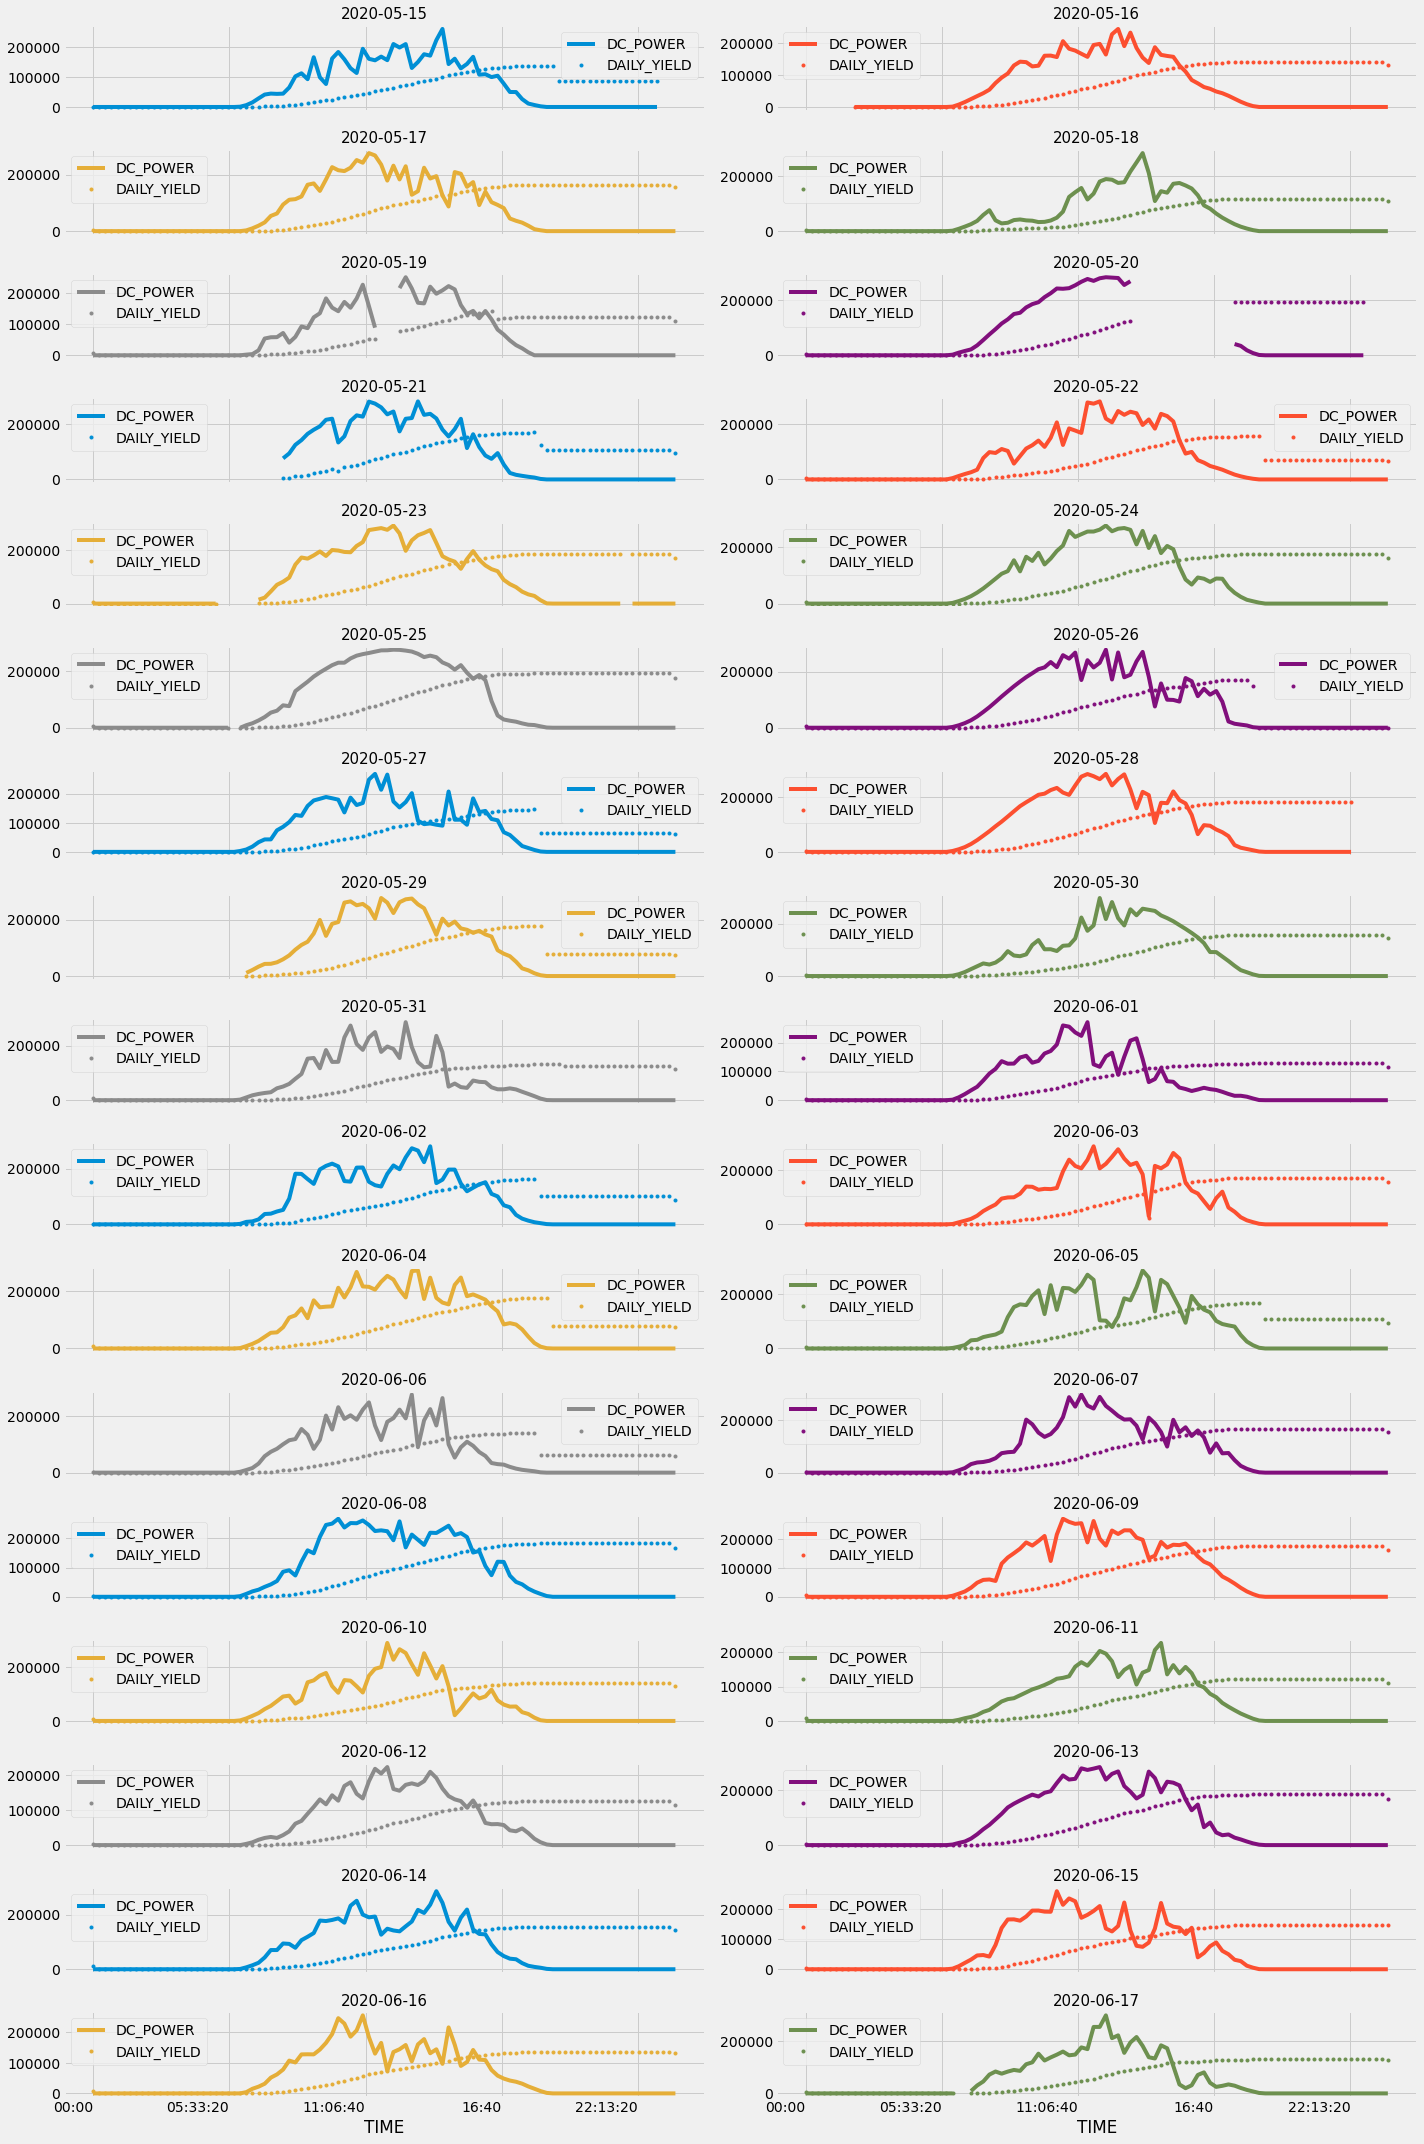

In [189]:
ax=group1.groupby(['TIME','DATE'])['DC_POWER'].mean().unstack().plot(subplots=True,layout=(17,2),figsize=(20,30))
group1.groupby(['TIME','DATE'])['DAILY_YIELD'].mean().unstack().plot(subplots=True,figsize=(20,30),style='.',ax=ax)

i=0
for a in range(len(ax)):
    for b in range(len(ax[a])):
        ax[a,b].set_title(group1.groupby(['TIME','DATE'])['DC_POWER'].mean().unstack().columns[i],size=15)
        ax[a,b].legend(['DC_POWER','DAILY_YIELD'])
        i=i+1

plt.tight_layout()
plt.show()

We can observe that some moments on days 19 to 21.05.20 data is missing.-That happens because of various reasons - e.g. sometimes an inverter or two goes down, sometimes they are deliberately taken down for maintenance or taken offline to avoid power surges on the grid (this is done as per instructions from the local power grid management authorities).

## Can we predict the power generation for next couple of days?

In [190]:
from fbprophet import Prophet

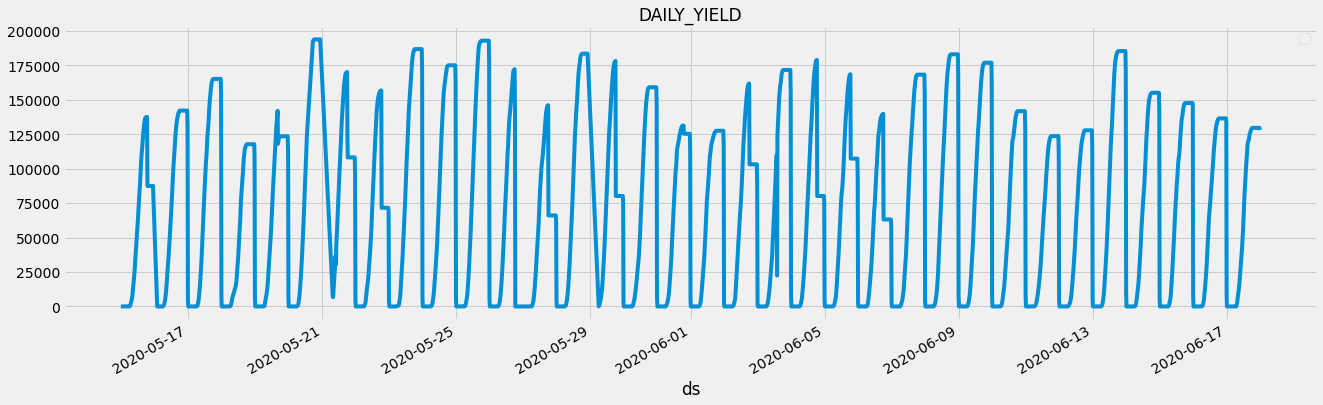

In [198]:
pred_gen1 = gen1.groupby('DATE_TIME')['DAILY_YIELD'].sum().reset_index().copy()
pred_gen1.rename(columns={'DATE_TIME':'ds','DAILY_YIELD':'y'},inplace=True)
pred_gen1.plot(x='ds',y='y',figsize=(20,6))
plt.legend('')
plt.title('DAILY_YIELD',size=17)
plt.show()

In [199]:
model = Prophet(interval_width=0.95, yearly_seasonality=True)
model.fit(pred_gen1)

In [200]:
future_dates = model.make_future_dataframe(periods = 96, freq = 'H',)
future_dates.tail()

,ds
3249,2020-06-21 19:45:00
3250,2020-06-21 20:45:00
3251,2020-06-21 21:45:00
3252,2020-06-21 22:45:00
3253,2020-06-21 23:45:00


In [201]:
forecast = model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3249,2020-06-21 19:45:00,126014.683524,73662.996502,175880.805615
3250,2020-06-21 20:45:00,131377.435074,80438.365453,179351.235197
3251,2020-06-21 21:45:00,129464.327902,80112.972025,180968.642965
3252,2020-06-21 22:45:00,106546.887773,56708.578191,159135.025933
3253,2020-06-21 23:45:00,63079.476244,9305.124103,110434.481808


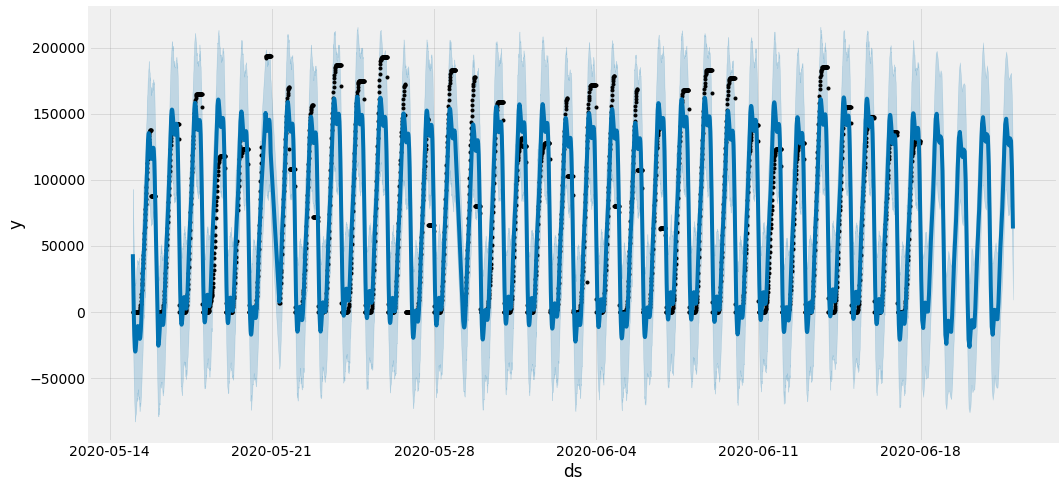

In [203]:
model.plot(forecast, uncertainty=True, figsize=(15,7));

In [204]:
from sklearn.metrics import r2_score

In [212]:
#Let's check the error in the last 2 days.
test=pred_gen1[-190:]

In [218]:
test.rename(columns={'DATE_TIME':'ds','DAILY_YIELD':'y'},inplace=True)
test_prophet=model.predict(test)

In [220]:
print('Prophet R2 Score: %f' % (r2_score(test['y'],test_prophet['yhat'])))

Prophet R2 Score: 0.918710
